In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Used to do plots
%matplotlib inline

import nltk 
from nltk.corpus import stopwords # Stopwords 
from nltk.tokenize import word_tokenize # Word_tokenizer
from nltk.stem.porter import PorterStemmer
from pattern.text.en import singularize

from pandarallel import pandarallel # Parallel workers on pandas dataframe

import unidecode
import re 
import time
import string
import statistics

from datetime import datetime

import contractions

In [2]:
df_reviews_dataset = pd.read_csv('IMDB/DS/dataset.csv')

In [3]:
df_reviews_dataset

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,review_text_count,cleaned_review_stemming,cleaned_review
0,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,9,redempt without doubt one brilliant movi ever ...,redemption without doubt one brilliant movie e...
1,9 October 2005,tt0111161,ur6574726,True,I have been a fan of this movie for a long tim...,9,This Movie Saved My Life.,7,fan movi long time seem ever time life hit dow...,fan movie long time seem ever time life hit do...
2,4 February 2012,tt0111161,ur31182745,True,I made my account on IMDb Just to Rate this mo...,10,Movie you can see 1000 times,8,made account rate movi someon robin done great...,made account rate movie someone robin done gre...
3,24 October 2008,tt0111161,ur9871443,True,"A friend of mine listed ""The Shawshank Redempt...",10,The Shawshank Redemption,6,friend mine list redempt one time favorit movi...,friend mine listed redemption one time favorit...
4,1 June 2010,tt0111161,ur23169472,True,"To tell the truth, I am speechless. I am a you...",10,"Blatantly Simple, yet Utterly Beautiful",9,tell truth young movi fanat fact film came yea...,tell truth young movie fanatic fact film came ...
...,...,...,...,...,...,...,...,...,...,...
279665,14 August 1999,tt0139239,ur0415521,False,This type of movie is one that I would not ord...,9,GO see it!,5,type movi one would ordinarili see howev becom...,type movie one would ordinarily see however be...
279666,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties,4,go wise fast pure entertain except cast turn m...,go wise fast pure entertainment exceptional ca...
279667,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie,7,well shall say one fun rate three one point go...,well shall say one fun rate three one point go...
279668,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?,7,call teenag version pulp fiction whatev want p...,call teenage version pulp fiction whatever wan...


### Undersampling

In [4]:
df_non = df_reviews_dataset[df_reviews_dataset['is_spoiler'] == False]
df_spoiler = df_reviews_dataset[df_reviews_dataset['is_spoiler'] == True]
print("nonspoiler:", len(df_non))
print("spoiler:", len(df_spoiler))

nonspoiler: 227256
spoiler: 52414


In [5]:
df_train = df_reviews_dataset.sample(frac = .80)
df_test = df_reviews_dataset.drop(df_train.index)

In [6]:
df_train['review_text'] = df_train['review_text'].apply(str)
df_train['cleaned_review_stemming'] = df_train['cleaned_review_stemming'].apply(str)
df_train['cleaned_review'] = df_train['cleaned_review'].apply(str)

df_test['review_text'] = df_test['review_text'].apply(str)
df_test['cleaned_review_stemming'] = df_test['cleaned_review_stemming'].apply(str)
df_test['cleaned_review'] = df_test['cleaned_review'].apply(str)

Divide the dataset in X and y, we load the dataset with stemming to check if the stemming is useful to improve the model measures.

In [7]:
X = df_train.cleaned_review
X_stemming = df_train.cleaned_review_stemming
y = df_train.is_spoiler

### Model Evaluation & Selection
in this section we have performed all the operation needed to evalute and select the model. As the task is a binary classification problem, we have analyzed the performances of three types of classification models:

- Naive Bayes Multinomial
- Support Vector Machine
- Logistic Regression

To do these operations and handle the dataset distribution we have used the sklean and imblearn libraries. \ We have performed the K-cross validation to evalute the model and select it.

In [8]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [9]:
def print_kfold_scores(scores):
    print("Accuracy = ", scores['test_accuracy'])
    print("")
    print("Precision = ", scores['test_precision'])
    print("")
    print("Recall = ", scores['test_recall'])
    print("")
    print("F1 score = ", scores['test_f1_score'])
    print("\n-----------------------------------------------------\n")
    print("fit_time (s) = ", scores['fit_time'])
    print("")
    print("score_time (s) = ", scores['score_time'])

In [10]:
def print_cross_validation(score, stemming):
    if stemming:
        print("--------------    K-FOLD WITH STEMMING    --------------\n")
        print_kfold_scores(score)
    else:
        print("--------------    K-FOLD WITHOUT STEMMING    --------------\n")
        print_kfold_scores(score)

In [11]:
scoring = {
    'accuracy' : make_scorer(accuracy_score), 
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score), 
    'f1_score' : make_scorer(f1_score)
}

In [12]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_folds)

In [13]:
def apply_cross_validation(clf, X, y, ngrams = (1,1), sampling_ratio = -1, n_jobs = 5, stemming = False):
    '''
    
    '''
    
    if sampling_ratio == -1: 
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('clf', clf)
        ])
    else:
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('rus', RandomUnderSampler(sampling_strategy=sampling_ratio)),
            ('clf', clf)
        ])
    
    score = cross_validate(clf_pipeline, X, y, cv = skf, scoring=scoring, n_jobs = n_jobs)
    
    print_cross_validation(score, stemming)
    
    return clf_pipeline, score

### COMPARE MODELS USING DATASET DISTRIBUTION
- We have applied the cross-validation with imbalanced-distribution to compare how classifier works on the general dataset and decide which models analyze in more details.

1. MULTINOMIAL

In [14]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(MultinomialNB(), X, y) 

# Register average precision and recall
avg_multinomial_precision = statistics.mean(score['test_precision'])
avg_multinomial_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.81210333 0.81255028 0.81286314 0.8123715  0.81250559 0.81223742
 0.81182676 0.81303357 0.81289948 0.81303357]

Precision =  [0.48235294 0.54320988 0.57       0.52       0.54117647 0.50549451
 0.45454545 0.60227273 0.57425743 0.59574468]

Recall =  [0.00975958 0.0104737  0.0135682  0.01237506 0.01094717 0.01094717
 0.01071174 0.01261604 0.01380624 0.01333016]

F1 score =  [0.01913206 0.02055114 0.02650546 0.0241748  0.02146023 0.02143024
 0.02093023 0.02471439 0.0269642  0.02607683]

-----------------------------------------------------

fit_time (s) =  [9.75337577 9.68806481 9.78513384 9.77080894 9.63495302 9.89737844
 9.85426545 9.81408715 9.72866201 9.72205997]

score_time (s) =  [1.16839933 1.22708726 1.18064737 1.18274403 1.22495174 1.1568315
 1.12321687 1.11923027 1.07829309 0.97907543]


2. SVM

In [15]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y)

# Register average precision and recall
avg_svm_precision = statistics.mean(score['test_precision'])
avg_svm_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.8217574  0.81934388 0.82274068 0.82166801 0.81898632 0.81813712
 0.8194252  0.82362669 0.82304564 0.8194252 ]

Precision =  [0.57210562 0.5554007  0.58557902 0.57910448 0.55436338 0.54829339
 0.56075472 0.58799172 0.58437936 0.55532646]

Recall =  [0.20114259 0.18971673 0.191383   0.18467396 0.18443598 0.17967634
 0.17686265 0.20280886 0.19947632 0.19233516]

F1 score =  [0.29764001 0.2828247  0.28848224 0.28004331 0.27678571 0.27065782
 0.2689106  0.30159292 0.2974268  0.28571429]

-----------------------------------------------------

fit_time (s) =  [17.06178093 16.9516685  16.95773196 16.96609688 16.81400681 17.0769465
 17.11496735 17.06913781 16.92677402 16.84179902]

score_time (s) =  [1.1210742  1.21220088 1.23425722 1.24280357 1.273525   1.17075491
 1.13929176 1.10042357 1.09891558 1.01708007]


3. LOGISTIC

In [16]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y)

# Register average precision and recall
avg_logistic_precision = statistics.mean(score['test_precision'])
avg_logistic_recall = statistics.mean(score['test_recall'])

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.82502011 0.82211495 0.82618218 0.82528828 0.82233843 0.82287477
 0.82317973 0.82635319 0.82635319 0.823582  ]

Precision =  [0.61644951 0.5942029  0.63953488 0.62575107 0.59843886 0.60565871
 0.61106074 0.62741935 0.63255034 0.60744501]

Recall =  [0.18019519 0.16591288 0.17019757 0.17348881 0.16420752 0.16301761
 0.16043799 0.185194   0.17948108 0.17091169]

F1 score =  [0.27887272 0.2593971  0.26884753 0.27166015 0.25770308 0.25689106
 0.25414781 0.28597684 0.27962173 0.26676574]

-----------------------------------------------------

fit_time (s) =  [24.99494815 25.48820376 25.5327189  25.36969948 24.96554852 26.06117845
 26.23684382 26.15600753 26.58470559 26.47980547]

score_time (s) =  [1.37415314 1.26216388 1.32508373 1.33406043 1.3629787  1.32071185
 1.2216444  1.1278367  0.97446966 0.972188  ]


---

In [17]:
pd.DataFrame([
    [avg_multinomial_precision, avg_multinomial_recall],
    [avg_svm_precision, avg_svm_recall],
    [avg_logistic_precision, avg_logistic_recall]
], index = ['Multinomial', 'SVM', 'Logistic'], columns=['AVG_Precision', 'AVG_Recall'])

,AVG_Precision,AVG_Recall
Multinomial,0.538905,0.011854
SVM,0.568330,0.190251
Logistic,0.615851,0.171304


COMPARE THE MODELS PLOTTING AVG PRECISION-RECALL

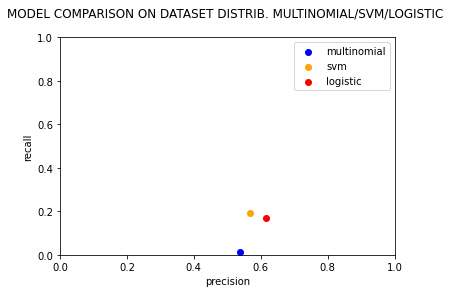

In [18]:
plt.scatter(avg_multinomial_precision, avg_multinomial_recall, color ='blue')
plt.scatter(avg_svm_precision, avg_svm_recall, color ='orange')
plt.scatter(avg_logistic_precision, avg_logistic_recall, color ='red')
labels = ["multinomial", "svm", "logistic"]

plt.xlim([0, 1]) 
plt.ylim([0, 1]) 

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=labels)

plt.title('MODEL COMPARISON ON DATASET DISTRIB. MULTINOMIAL/SVM/LOGISTIC \n')

plt.show()

As we can see from the plot, the multinomial model works really bad in terms of precision and recall in respect to the other two classifiers. 

Due to this, we have decided to perform the analysis changing parameters and distribution only to SVM and Logistic models.

### COMPARING SVM AND LOGISTIC SCORE
In this section we have compared the SVM and Logistic model changing parameters of CountVectorizer and the distribution of the classes.

We have also analyzed if the stemming is relevant in terms of increasing the model's performances.

#### SVM

In [19]:
from sklearn.svm import LinearSVC
svm_pipelines = []
svm_scores = []

Ngram_range (1,1) & Undersampling 50/50

In [20]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = 1)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.67851077 0.67359435 0.67278985 0.67457763 0.67444355 0.67287923
 0.67018281 0.67098735 0.67880928 0.66951236]

Precision =  [0.32478332 0.31765812 0.31525343 0.32113396 0.31789175 0.31666863
 0.31270627 0.3155929  0.32174848 0.31515573]

Recall =  [0.66008093 0.6431802  0.63365865 0.65778201 0.64017135 0.64064731
 0.63151631 0.64365627 0.64127589 0.64794097]

F1 score =  [0.43535599 0.42527741 0.42103598 0.43157155 0.42482628 0.42383689
 0.41828932 0.42352573 0.42850326 0.42405359]

-----------------------------------------------------

fit_time (s) =  [13.36368608 13.30826783 13.12654185 13.28317261 13.11659908 13.5025115
 13.34477353 13.43400574 13.30382872 13.20659471]

score_time (s) =  [1.24107504 1.25089502 1.26057625 1.35288167 1.32147765 1.15340805
 1.12901425 1.09453011 1.09706855 1.01444101]


In [21]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = 1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.69370698 0.6952266  0.69062304 0.69227675 0.68910342 0.68534907
 0.68841908 0.68605015 0.69373799 0.68381531]

Precision =  [0.34085454 0.33958333 0.33374068 0.33939902 0.33365547 0.32758202
 0.33130329 0.33407782 0.33706208 0.33010053]

Recall =  [0.67602952 0.65960486 0.65008331 0.67467872 0.65730604 0.64159924
 0.64746489 0.67650559 0.65270174 0.66436563]

F1 score =  [0.45320354 0.4483456  0.44105297 0.4516129  0.44262821 0.43371943
 0.43832084 0.44727731 0.44455253 0.44105563]

-----------------------------------------------------

fit_time (s) =  [12.43477869 11.78204226 12.30097461 12.00825095 12.6511724  13.34980512
 13.51515937 12.99782038 12.39412379 11.92814064]

score_time (s) =  [1.26102138 1.24485946 1.2338438  1.24940348 1.29055524 1.16966581
 1.07318282 1.14133143 1.12437963 1.133744  ]


Ngram_range (1,1) & distribution 60 (no spoiler), 40 (spoiler)

In [22]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = (40/60))
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.74488245 0.74054706 0.74220077 0.74698311 0.74233485 0.74483776
 0.74397712 0.74156349 0.7442453  0.73968623]

Precision =  [0.37380673 0.36267123 0.36718088 0.37625106 0.36769934 0.36965923
 0.36829395 0.36725441 0.37002222 0.36548981]

Recall =  [0.53130207 0.50416567 0.51559153 0.52784388 0.51689672 0.50856735
 0.50821233 0.52059034 0.51535349 0.52487503]

F1 score =  [0.43885175 0.42187033 0.42891089 0.43933842 0.42971609 0.42812782
 0.42708542 0.43068137 0.43076005 0.43091655]

-----------------------------------------------------

fit_time (s) =  [13.85874605 13.9204495  13.86495447 13.66720271 13.64626384 13.97680163
 13.97917342 14.0220449  13.81183386 13.67850685]

score_time (s) =  [1.11512876 1.21328568 1.22967219 1.24291825 1.28863788 1.16691327
 1.12283278 1.08975124 1.03187513 0.99765182]


In [23]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, sampling_ratio = (40/60), stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.74729597 0.75440243 0.74743005 0.74823456 0.74376508 0.74711719
 0.74732937 0.74482635 0.74911724 0.74527332]

Precision =  [0.37734256 0.3846291  0.37217913 0.37754578 0.36925705 0.37299372
 0.37100213 0.37189942 0.37631395 0.37099552]

Recall =  [0.53201619 0.51344918 0.5024994  0.5249881  0.5145169  0.50880533
 0.49702452 0.52106641 0.51130683 0.51273506]

F1 score =  [0.44152509 0.43980018 0.42763091 0.43922349 0.42994929 0.43044091
 0.42486519 0.43402399 0.43354526 0.43049865]

-----------------------------------------------------

fit_time (s) =  [13.54676461 13.51324153 13.50414443 13.39620543 13.24312568 13.66385293
 13.52342892 13.55196667 13.45856285 13.26678443]

score_time (s) =  [1.1129384  1.12542009 1.14318466 1.20111299 1.23008537 1.09750366
 1.09197402 1.05860162 1.01624823 1.01680779]


Ngram_range (1,1) & dataset distribution

In [24]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.8217574  0.81934388 0.82274068 0.82166801 0.81898632 0.81813712
 0.8194252  0.82362669 0.82304564 0.8194252 ]

Precision =  [0.57210562 0.5554007  0.58557902 0.57910448 0.55436338 0.54829339
 0.56075472 0.58799172 0.58437936 0.55532646]

Recall =  [0.20114259 0.18971673 0.191383   0.18467396 0.18443598 0.17967634
 0.17686265 0.20280886 0.19947632 0.19233516]

F1 score =  [0.29764001 0.2828247  0.28848224 0.28004331 0.27678571 0.27065782
 0.2689106  0.30159292 0.2974268  0.28571429]

-----------------------------------------------------

fit_time (s) =  [17.49600363 17.53943896 17.56467748 17.48987532 17.18285251 17.61738396
 17.4307723  17.56217241 17.47331595 17.22591615]

score_time (s) =  [1.12421823 1.20461154 1.232728   1.26596141 1.26502895 1.13923311
 1.14980316 1.12899566 1.06583261 1.04694152]


In [25]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.8217127  0.82028247 0.82296415 0.82153392 0.81943327 0.81925449
 0.82157064 0.82362669 0.82295624 0.81982747]

Precision =  [0.57714702 0.56880734 0.59724473 0.58069498 0.56428571 0.56330128
 0.58530612 0.59579264 0.58995502 0.56458967]

Recall =  [0.18876458 0.17710069 0.17543442 0.1789624  0.16920514 0.16730129
 0.17067365 0.18876458 0.18733635 0.17686265]

F1 score =  [0.2844843  0.27010347 0.27120515 0.27360378 0.2603442  0.25798165
 0.26428308 0.28669559 0.28437218 0.26934928]

-----------------------------------------------------

fit_time (s) =  [17.17745757 17.13924551 17.19816566 17.08245015 16.90105534 17.24205828
 17.3421793  17.15229321 17.12996697 16.96010995]

score_time (s) =  [1.12699485 1.11343241 1.13537931 1.2313478  1.24806452 1.11704135
 1.09710336 1.0873208  1.04832339 1.02499819]


Ngram_range (1,2) & Undersampling 50/50

In [26]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = 1)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.65030839 0.64896755 0.64463216 0.6510682  0.64802896 0.64235273
 0.64457158 0.64305189 0.64962231 0.63817995]

Precision =  [0.31494535 0.31156505 0.30686032 0.31680049 0.31212276 0.30500821
 0.3094585  0.31057952 0.3134359  0.30553336]

Recall =  [0.73387289 0.71887646 0.70911688 0.74178962 0.72608282 0.70728225
 0.72506546 0.73863366 0.72744585 0.72815996]

F1 score =  [0.44074339 0.43472002 0.42835574 0.44398547 0.43657437 0.4262154
 0.43377955 0.43728861 0.4381048  0.430451  ]

-----------------------------------------------------

fit_time (s) =  [55.78311872 56.44199777 56.62289262 56.78600383 56.52613401 55.55833077
 55.26746106 55.92135143 55.89531422 55.85310364]

score_time (s) =  [3.87809181 3.82189488 3.7467165  3.86187792 3.89999318 4.11971903
 3.91214585 3.57400465 3.5021069  3.49125719]


In [27]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = 1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.65428623 0.65647627 0.64825244 0.65285599 0.65442031 0.64905694
 0.64604657 0.64698521 0.65766772 0.65033746]

Precision =  [0.31635835 0.31655964 0.30884651 0.31534238 0.31618413 0.30941938
 0.30691732 0.30957041 0.31653226 0.31275848]

Recall =  [0.72458938 0.71578196 0.7055463  0.72441694 0.72251309 0.70514041
 0.70340395 0.71530588 0.71006903 0.72006665]

F1 score =  [0.44042538 0.4389781  0.42962748 0.43940816 0.4398725  0.43010597
 0.42736279 0.4321254  0.43787156 0.4360989 ]

-----------------------------------------------------

fit_time (s) =  [52.71935916 52.79030704 53.5796001  52.93450332 52.79245853 54.41617513
 54.23017001 54.24479795 54.14308882 54.2187705 ]

score_time (s) =  [3.67894197 3.60778046 3.85823441 3.78018332 3.76235127 3.75291514
 3.73737574 3.66697884 3.70993781 3.65506959]


Ngram_range (1,2) & distribution 60 (no spoiler), 40 (spoiler)

In [28]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = (40/60))
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.72950746 0.72812193 0.72682578 0.73379816 0.72490391 0.72271386
 0.72305904 0.72194163 0.72766281 0.72529388]

Precision =  [0.36750179 0.36290793 0.36154181 0.37185856 0.35902988 0.35505358
 0.35612289 0.35980011 0.36411951 0.36029306]

Recall =  [0.61104499 0.59295406 0.59390621 0.60566397 0.59186102 0.58353165
 0.58771721 0.61699595 0.60342776 0.59700071]

F1 score =  [0.45896657 0.45024853 0.44946856 0.46080029 0.44694043 0.44148362
 0.44350638 0.45453748 0.45417898 0.44938183]

-----------------------------------------------------

fit_time (s) =  [58.89837217 59.30484891 59.23475599 59.37339926 59.28788185 58.20615625
 57.85633349 58.19367385 57.94265389 58.17598009]

score_time (s) =  [3.81152439 3.64686775 3.66855526 3.9506495  4.03168535 3.8396709
 3.72829103 3.64212704 3.60109949 3.51483536]


In [29]:
# Without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = (40/60), stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.73303835 0.73040136 0.72928399 0.73098239 0.72861357 0.72709395
 0.72538327 0.7277075  0.72998704 0.72614312]

Precision =  [0.37073242 0.36226869 0.3614098  0.36684743 0.36213506 0.35892116
 0.35690087 0.36444444 0.36518171 0.35958005]

Recall =  [0.60485599 0.57319686 0.57605332 0.59566873 0.58448358 0.57639219
 0.57676744 0.60509403 0.5931921  0.58700309]

F1 score =  [0.45970149 0.4439528  0.44415894 0.45405896 0.44719592 0.44237443
 0.44094631 0.45490336 0.45206349 0.44597161]

-----------------------------------------------------

fit_time (s) =  [54.46369338 54.44302654 54.77574134 54.85580254 54.4465816  55.07796383
 54.08552599 54.63382745 54.79610348 54.75758576]

score_time (s) =  [3.62013984 3.61518669 3.67638969 3.84361362 3.8685627  3.70444465
 3.81071305 3.62987614 3.42657495 3.45112371]


- Ngram_range (1,2) & dataset distribution

In [30]:
# with stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.8208635  0.81795834 0.82010369 0.82215965 0.81742201 0.81925449
 0.81973808 0.82090019 0.82277745 0.81902293]

Precision =  [0.54396355 0.53073967 0.5415879  0.5517882  0.52763344 0.53726415
 0.54034582 0.54449541 0.55592417 0.53473492]

Recall =  [0.28421804 0.26303261 0.27279219 0.28272251 0.2658258  0.2710614
 0.26779338 0.28255177 0.27921923 0.27850512]

F1 score =  [0.37335835 0.3517428  0.36283046 0.37387884 0.35353695 0.36032901
 0.35810918 0.372042   0.3717319  0.3662545 ]

-----------------------------------------------------

fit_time (s) =  [68.7529273  68.6515882  69.32937551 68.93294525 69.01370215 68.83591413
 69.28380823 68.91238403 69.33704901 69.3510952 ]

score_time (s) =  [3.86613083 3.79836631 3.92848825 3.96937537 4.11401391 4.13914633
 3.88194919 3.79463863 3.58052158 3.57120275]


In [31]:
# without stemming
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.82135514 0.81764548 0.81947797 0.81889693 0.81684098 0.81844999
 0.81844187 0.82166004 0.82389487 0.8193805 ]

Precision =  [0.54761905 0.53035625 0.53982301 0.53554502 0.52539062 0.53365385
 0.53504791 0.54969383 0.56450816 0.53791469]

Recall =  [0.27921923 0.25160676 0.26136634 0.26891956 0.25606854 0.26415992
 0.25255891 0.277791   0.27184004 0.27017377]

F1 score =  [0.36985653 0.34129803 0.35220529 0.35804816 0.34432    0.35339064
 0.3431436  0.36907021 0.36696658 0.35968943]

-----------------------------------------------------

fit_time (s) =  [64.28456593 65.0122118  65.57009673 64.71496868 65.06185794 64.44193578
 65.07159591 64.87414885 64.65804887 64.68820906]

score_time (s) =  [3.89862585 3.82176805 3.79108858 3.79408097 3.99165964 4.07722807
 3.59216976 3.49630713 3.53060603 3.53421259]


#### Logsitic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
logistic_pipelines = []
logistic_scores = []

- Ngram_range (1,1) & Undersampling 50/50

In [33]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = 1)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.69401984 0.69616519 0.69227675 0.69334942 0.69160633 0.68646643
 0.68998346 0.68622894 0.69324632 0.68587136]

Precision =  [0.34163573 0.33963196 0.33537782 0.33941297 0.33484329 0.32937037
 0.33317067 0.33446858 0.3364463  0.3315457 ]

Recall =  [0.67912402 0.65460605 0.65079743 0.66872918 0.65088053 0.64612089
 0.65008331 0.67793383 0.65174958 0.66222328]

F1 score =  [0.45458891 0.44722719 0.44264551 0.45028443 0.44219887 0.43631981
 0.44055493 0.4479396  0.44379609 0.44186785]

-----------------------------------------------------

fit_time (s) =  [11.86756134 12.88367748 11.60100079 12.50215602 11.76422977 12.72109485
 13.56477404 12.33409262 12.52179599 12.5749979 ]

score_time (s) =  [1.3509903  1.34340906 1.31822181 1.34287119 1.33639145 1.36560059
 1.10827231 1.22208285 1.05299115 1.01284313]


In [34]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = 1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.69232144 0.69428801 0.68660052 0.69258961 0.68780728 0.68812014
 0.68475394 0.68578197 0.69601752 0.6867206 ]

Precision =  [0.33939902 0.33779963 0.32936749 0.33898917 0.33345302 0.33236715
 0.32769454 0.33214667 0.33950617 0.33289693]

Recall =  [0.67483932 0.65412997 0.64579862 0.67039505 0.66301761 0.65492623
 0.64556058 0.66626994 0.65460605 0.66579386]

F1 score =  [0.45164888 0.44552529 0.43624377 0.45028772 0.44373656 0.44095498
 0.43471988 0.4433006  0.44711812 0.44386257]

-----------------------------------------------------

fit_time (s) =  [13.10775471 12.52542448 11.94643378 11.96230054 12.67933154 12.50559902
 13.44752979 12.44135785 12.90065432 12.77230644]

score_time (s) =  [1.29532528 1.2785995  1.20193505 1.31023908 1.31423926 1.27775455
 1.02723551 1.22590637 1.03306317 0.90795755]


- Ngram_range (1,1) & distribution 60 (no spoiler), 40 (spoiler)

In [35]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = (40/60))
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.7682578  0.76977742 0.76928578 0.77093948 0.76562081 0.76347546
 0.76824744 0.7646717  0.77083985 0.76592321]

Precision =  [0.40681818 0.40620063 0.40569185 0.41217888 0.39863813 0.3939276
 0.40468811 0.3998494  0.40992218 0.39996138]

Recall =  [0.51130683 0.48964532 0.49202571 0.51546882 0.48762494 0.48167539
 0.49726256 0.50559391 0.50154725 0.49297786]

F1 score =  [0.45311676 0.4440367  0.4447074  0.45807338 0.4386641  0.43340471
 0.4462245  0.44654683 0.45112943 0.44162491]

-----------------------------------------------------

fit_time (s) =  [16.02951837 16.23105145 15.61736202 16.46799731 16.15307999 16.48338246
 15.38330317 16.49982238 15.08833885 15.97330689]

score_time (s) =  [1.30752301 1.32103729 1.30242109 1.36017299 1.34231663 1.19202256
 1.33544874 1.02394867 1.2313993  0.95200205]


In [36]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = (40/60), stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.76986681 0.76705104 0.76642532 0.76879414 0.7682578  0.76490569
 0.76440352 0.76726411 0.77039288 0.76793456]

Precision =  [0.41066717 0.40228107 0.39913403 0.40909942 0.40447036 0.39748062
 0.39659838 0.40382409 0.40754642 0.40395425]

Recall =  [0.51868603 0.49535825 0.4827422  0.51999048 0.49524036 0.4881009
 0.48845513 0.50273744 0.49107355 0.49607236]

F1 score =  [0.45839907 0.44399403 0.43697479 0.45792728 0.44527656 0.43815424
 0.43776    0.44788464 0.44542805 0.44529915]

-----------------------------------------------------

fit_time (s) =  [14.80483532 12.86755109 14.82444954 15.79168653 15.09590173 14.49792194
 15.24850583 15.15310168 15.05651999 15.19987178]

score_time (s) =  [1.29555368 1.29537296 1.26393509 1.22339082 1.27632761 1.3321116
 1.13030624 1.10742593 0.97195172 0.87317061]


- Ngram_range (1,1) & dataset distribution

In [37]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.82502011 0.82211495 0.82618218 0.82528828 0.82233843 0.82287477
 0.82317973 0.82635319 0.82635319 0.823582  ]

Precision =  [0.61644951 0.5942029  0.63953488 0.62575107 0.59843886 0.60565871
 0.61106074 0.62741935 0.63255034 0.60744501]

Recall =  [0.18019519 0.16591288 0.17019757 0.17348881 0.16420752 0.16301761
 0.16043799 0.185194   0.17948108 0.17091169]

F1 score =  [0.27887272 0.2593971  0.26884753 0.27166015 0.25770308 0.25689106
 0.25414781 0.28597684 0.27962173 0.26676574]

-----------------------------------------------------

fit_time (s) =  [25.56415105 25.95789576 26.19044495 25.77031469 25.33774352 26.25724387
 26.31603169 26.72008801 26.84198165 26.75001454]

score_time (s) =  [1.34671545 1.24187016 1.2904253  1.29541087 1.30694199 1.41382003
 1.28543496 1.10526848 1.00904393 0.98559499]


In [38]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.82372397 0.82211495 0.82645034 0.82609279 0.82180209 0.82358988
 0.82206231 0.82729182 0.82662137 0.82376078]

Precision =  [0.60388036 0.5918537  0.64145907 0.62947544 0.59180188 0.6123348
 0.59963768 0.63490793 0.63349917 0.60661157]

Recall =  [0.17781481 0.16948346 0.1716258  0.17991433 0.16492147 0.16539743
 0.15758153 0.18876458 0.18186146 0.1747203 ]

F1 score =  [0.27473336 0.26350851 0.27079812 0.27984453 0.25795645 0.26044594
 0.24957587 0.29100917 0.28259663 0.27129921]

-----------------------------------------------------

fit_time (s) =  [25.58416533 26.07714176 24.05246496 25.84112668 23.67539763 24.47962689
 24.32251072 25.29469824 25.40429497 23.93360281]

score_time (s) =  [1.35302711 1.24616981 1.29397964 1.21678281 1.3302598  1.28768253
 1.30478764 0.97026777 0.86576772 1.01950788]


Ngram_range (1,2) & Undersampling 50/50

In [39]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = 1)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.6561634  0.65987307 0.65357111 0.65857692 0.65902387 0.64986145
 0.6525723  0.65368972 0.65896393 0.65136549]

Precision =  [0.31973983 0.3213874  0.31552692 0.32175086 0.32085729 0.31122661
 0.31457641 0.31827031 0.3206027  0.3162463 ]

Recall =  [0.73720543 0.73006427 0.72268507 0.7382199  0.73036649 0.71251785
 0.72125684 0.73934777 0.72935015 0.73720543]

F1 score =  [0.44602866 0.44630384 0.43926789 0.44816875 0.44584877 0.4332224
 0.43808285 0.44498567 0.44541358 0.44261826]

-----------------------------------------------------

fit_time (s) =  [196.28216577 164.16680312 114.08972406 207.13776422 223.51246214
 195.5648098  231.82255745 216.57168555 212.57647657 207.42580533]

score_time (s) =  [5.26806593 5.61530805 6.10427165 5.11218739 4.23871255 6.07371354
 5.34121823 4.5128901  3.47869039 2.61602831]


In [40]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = 1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.66420846 0.6697953  0.6604541  0.66273353 0.66251006 0.66143738
 0.66052832 0.66227149 0.66629419 0.65677379]

Precision =  [0.32524272 0.32726287 0.31820128 0.32385166 0.32150091 0.31863641
 0.31916027 0.32377351 0.32530765 0.31713985]

Recall =  [0.73363485 0.71863842 0.70745061 0.7315564  0.71775345 0.70514041
 0.71292549 0.73363485 0.72363723 0.7179243 ]

F1 score =  [0.45068363 0.44972442 0.43896315 0.44895575 0.44408452 0.43893045
 0.44092749 0.44927114 0.44884099 0.43993874]

-----------------------------------------------------

fit_time (s) =  [183.40485287 113.42941117 191.79283524 190.51229453 190.6354053
 202.88349986 102.62709975 169.31233907 151.04745746 141.32075596]

score_time (s) =  [5.37280941 5.84654498 4.01361847 3.87412977 3.80742645 5.13308144
 6.01491261 2.49920106 3.4302597  4.4107461 ]


Ngram_range (1,2) & distribution 60 (no spoiler), 40 (spoiler)

In [41]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = (40/60))
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.75507285 0.75623492 0.75498346 0.75511755 0.75417896 0.74948601
 0.75023466 0.75403388 0.75774371 0.7496983 ]

Precision =  [0.39375312 0.3942259  0.39142227 0.39506984 0.39201331 0.38267269
 0.3840107  0.39390482 0.39747687 0.3850074 ]

Recall =  [0.56415139 0.55582004 0.54963104 0.57210852 0.56068539 0.54450262
 0.54653654 0.5753392  0.56248512 0.55748631]

F1 score =  [0.46379648 0.46128013 0.45722772 0.46738602 0.46141794 0.44946469
 0.45108055 0.46764051 0.46579933 0.4554648 ]

-----------------------------------------------------

fit_time (s) =  [267.75034833 290.05961061 263.35489178 288.95649719 258.93068981
 284.08415914 223.98428631 259.40863538 291.68020535 274.31743073]

score_time (s) =  [5.26747346 3.50428581 5.55604529 3.53643966 6.01528883 4.40477824
 6.01951718 5.18867326 2.55798149 3.43687987]


In [42]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = (40/60), stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.76217932 0.75735228 0.75690534 0.75712881 0.75762045 0.75677125
 0.75524069 0.75689447 0.76212399 0.75658159]

Precision =  [0.40358127 0.39355062 0.39234783 0.39654014 0.39533688 0.39299275
 0.3902565  0.39631491 0.40280909 0.39371692]

Recall =  [0.55796239 0.54034754 0.537015   0.5618753  0.54878629 0.54188482
 0.53963342 0.56319924 0.55296358 0.54891692]

F1 score =  [0.46837846 0.45541178 0.45342177 0.46494683 0.45959143 0.45558223
 0.45294705 0.46524432 0.46609149 0.45854047]

-----------------------------------------------------

fit_time (s) =  [216.76100731 231.09925556 244.34479427 236.9788959  195.74998045
 236.07643628 243.45085311 248.27895236 240.24191689 184.6690793 ]

score_time (s) =  [5.33759809 4.81899118 3.35666132 4.12710118 5.82147431 5.15049076
 4.3146565  2.63106275 3.13179064 5.97711802]


Ngram_range (1,2) & dataset distribution

In [43]:
# with stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITHOUT STEMMING    --------------

Accuracy =  [0.82698668 0.82193618 0.8276571  0.82586931 0.82385805 0.82519889
 0.82510169 0.82711304 0.82858803 0.82554865]

Precision =  [0.61163735 0.57733428 0.62655906 0.60309973 0.59119497 0.60239268
 0.60588235 0.6127285  0.62997159 0.6       ]

Recall =  [0.21518686 0.19281124 0.20328493 0.21299381 0.2013327  0.20371252
 0.19614378 0.2154249  0.2111402  0.21280647]

F1 score =  [0.31836591 0.28907923 0.3069734  0.3148083  0.3003728  0.30446381
 0.29634958 0.31877422 0.31627741 0.31418028]

-----------------------------------------------------

fit_time (s) =  [348.6151979  308.73145199 353.75003171 344.5771575  306.23685741
 271.16840124 340.40136075 343.53590608 327.32927632 331.63177156]

score_time (s) =  [4.5170188  5.60910273 3.72588706 4.79079223 5.4966135  5.95300055
 5.2306602  2.63421535 4.41195798 3.42201734]


In [44]:
# without stemming
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

--------------    K-FOLD WITH STEMMING    --------------

Accuracy =  [0.82729954 0.82269599 0.82712077 0.82555645 0.82336641 0.82573523
 0.82393957 0.82729182 0.82800697 0.82604032]

Precision =  [0.61693269 0.58602941 0.62528217 0.60491228 0.58967001 0.61147903
 0.59984756 0.6174216  0.62688713 0.61059413]

Recall =  [0.21161628 0.18971673 0.19781005 0.20514041 0.19562113 0.19776297
 0.18733635 0.21090217 0.20756963 0.20304689]

F1 score =  [0.31513648 0.28663909 0.3005425  0.30637995 0.29378127 0.29886711
 0.28550698 0.31440738 0.31187411 0.3047517 ]

-----------------------------------------------------

fit_time (s) =  [326.76679373 343.26364994 312.41493011 307.85305905 335.32762313
 332.67127824 351.89937305 340.43523479 331.05801034 325.81952381]

score_time (s) =  [4.78533077 3.27710891 5.40355873 5.69420028 4.10767126 5.81059647
 3.55238986 3.2229228  3.25329781 3.2253983 ]


---

In [45]:
indexes=[
    "ngram_1_1-sample5050",
    "ngram_1_1-sample5050_stem",
    "ngram_1_1-sample6040",
    "ngram_1_1-sample6040_stem",
    "ngram_1_1-sampledataset",
    "ngram_1_1-sampledataset_stem",
    "ngram_1_2-sample5050",
    "ngram_1_2-sample5050_stem",
    "ngram_1_2-sample6040",
    "ngram_1_2-sample6040_stem",
    "ngram_1_2-sampledataset",
    "ngram_1_2-sampledataset_stem",
]

def create_df_scores(scores):
    list_scores_precision = []
    list_scores_recall = []
    for x in scores:
        list_scores_precision.append(x['test_precision'])
        list_scores_recall.append(x['test_recall'])      
                                       
    score_df_precision = pd.DataFrame(list_scores_precision, index=indexes)
    score_df_recall = pd.DataFrame(list_scores_recall, index=indexes)
                                       
    score_df_precision['mean'] = score_df_precision.mean(axis=1)
    score_df_recall['mean'] = score_df_recall.mean(axis=1)
    
    score_df = pd.DataFrame([score_df_precision['mean'],score_df_recall['mean']]).T
    score_df.columns = ['avg_precision', 'avg_recall']
    
    return score_df

### SVM Score

In [46]:
svm_df_scores = create_df_scores(svm_scores)
svm_df_scores

,avg_precision,avg_recall
ngram_1_1-sample5050,0.317859,0.643991
ngram_1_1-sample5050_stem,0.334736,0.660034
ngram_1_1-sample6040,0.368833,0.517340
ngram_1_1-sample6040_stem,0.374416,0.513841
ngram_1_1-sampledataset,0.568330,0.190251
ngram_1_1-sampledataset_stem,0.578712,0.178041
ngram_1_2-sample5050,0.310631,0.725633
ngram_1_2-sample5050_stem,0.312849,0.714683
ngram_1_2-sample6040,0.361823,0.598410
ngram_1_2-sample6040_stem,0.362842,0.587271


#### Drop SVM Stemming result

We decided to drop the SVM stemming results 'cause it doesn't improve the Accuracy and Precision

In [47]:
'''
svm_df_scores = svm_df_scores.drop(index=[
    'ngram_1_2-sampledataset_stem'
])
'''

"\nsvm_df_scores = svm_df_scores.drop(index=[\n    'ngram_1_2-sampledataset_stem'\n])\n"

### LOGISTIC REGRESSION SCORES

In [48]:
logistic_df_scores = create_df_scores(logistic_scores)
logistic_df_scores

,avg_precision,avg_recall
ngram_1_1-sample5050,0.335590,0.659225
ngram_1_1-sample5050_stem,0.334362,0.659534
ngram_1_1-sample6040,0.403788,0.497513
ngram_1_1-sample6040_stem,0.403506,0.497846
ngram_1_1-sampledataset,0.615851,0.171304
ngram_1_1-sampledataset_stem,0.614546,0.173209
ngram_1_2-sample5050,0.318018,0.729822
ngram_1_2-sample5050_stem,0.322008,0.720230
ngram_1_2-sample6040,0.390956,0.558875
ngram_1_2-sample6040_stem,0.395745,0.549258


#### Drop Logistic stemming result
- We decided to drop the Logistic stemming result 'cause it doesn't improve the Accuracy and Precision

In [49]:
'''
logistic_df_scores = logistic_df_scores.drop(index=[
    'ngram_1_2-sampledataset_stem'
])
'''

"\nlogistic_df_scores = logistic_df_scores.drop(index=[\n    'ngram_1_2-sampledataset_stem'\n])\n"

### EXTRACT ONLY RELEVANT RESULTS
We have considered as relevant results the results that had precision and recall > 0.45

In [50]:
def get_relevant_results(df_precision, df_recall):
    
    indexes_precision = df_precision.loc[(
        df_precision > 0.45
    )].index
    
    indexes_recall = df_recall.loc[(
        df_recall > 0.45
    )].index
    
    indexes = [x for x in indexes_precision if x in indexes_recall]
    
    return indexes

#### SVM RELEVANT RESULTS

In [51]:
svm_indexes = get_relevant_results(svm_df_scores['avg_precision'], svm_df_scores['avg_recall'])
svm_results = pd.DataFrame([svm_df_scores['avg_precision'].rename('precision'),svm_df_scores['avg_recall'].rename('recall')]).T.loc[svm_indexes]
svm_results

,precision,recall


###

In [52]:
logistic_indexes = get_relevant_results(logistic_df_scores['avg_precision'], logistic_df_scores['avg_recall'])
logistic_results = pd.DataFrame([logistic_df_scores['avg_precision'].rename('precision'),logistic_df_scores['avg_recall'].rename('recall')]).T.loc[logistic_indexes]
logistic_results

,precision,recall


### EVALUATE THE MODEL

In [53]:
labels = []
spoiler_list = []
spoiler_distribs = []
not_spoiler_list = []
not_spoiler_distribs = []

for fold in folds:
    # Extract month and year 
    month_year = datetime.strptime(fold['review_date'][0],"%Y-%m-%d").strftime('%Y-%m')
    
    # Number of the total review in the fold
    review_number = len(fold['is_spoiler'])
    
    # Number of spoiler/not spoiler review in the folt 
    spoiler = int(fold['is_spoiler'][fold['is_spoiler']==1].value_counts())
    not_spoiler = int(fold['is_spoiler'][fold['is_spoiler']==0].value_counts())
    
    # Compute distribution 
    spoiler_distrib = spoiler/review_number
    not_spoiler_distrib = not_spoiler/review_number
    
    # List to plot values
    labels.append(month_year)

    spoiler_list.append(spoiler)
    not_spoiler_list.append(not_spoiler)
    
    spoiler_distribs.append(spoiler_distrib)
    not_spoiler_distribs.append(not_spoiler_distrib)

    
# ------ PLOT ------ #
    
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

ax1.bar(labels, not_spoiler_list, width, label='Not_spoiler')
ax1.bar(labels, spoiler_list, width, bottom=not_spoiler_list, label='Spoiler')

ax1.set_ylabel('Number of instances')
ax1.set_title('Instances by month and spoiler')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()


ax2.bar(labels, not_spoiler_distribs, width, label='Not_spoiler')
ax2.bar(labels, spoiler_distribs, width, bottom=not_spoiler_distribs, label='Spoiler')

ax2.set_ylabel('Monthly distribution of spoilers')
ax2.set_title('Distribution percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.show()

NameError: name 'folds' is not defined